In [1]:
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [10]:
class deeponet(tf.keras.Model):
    def __init__(self):
        super(deeponet, self).__init__()
        self.trunk = tf.keras.Sequential([tf.keras.layers.Dense(128, activation='tanh'),
                        tf.keras.layers.Dense(64, activation='tanh'),
                        tf.keras.layers.Dense(16)])
        self.branch_1 = tf.keras.Sequential([tf.keras.layers.Dense(128, activation='tanh'),
                        tf.keras.layers.Dense(64, activation='tanh'),
                        tf.keras.layers.Dense(16)])
        self.branch_2 = tf.keras.Sequential([tf.keras.layers.Dense(128, activation='tanh'),
                        tf.keras.layers.Dense(64, activation='tanh'),
                        tf.keras.layers.Dense(16)])
        
        self.bias = tf.Variable(0., trainable=True)
        
    def call(self, inputs):
        func_1 = inputs[0]
        func_2 = inputs[1]
        loc = inputs[2]
        
        x1 = self.branch_1(func_1)
        x2 = self.branch_2(func_2)
        x2 = x1*x2
        
        x3 = self.trunk(loc)
        
        x4 = tf.einsum("bi,bi->b",x2,x3)
        x4 = tf.expand_dims(x4, axis=1) + self.bias
        
        return x4


def cal_grad(model, x, y, c, u):
    with tf.GradientTape() as tape:
        pred = model.call([x,y,c])
        loss_value = tf.reduce_mean(tf.square(u-pred))
        #loss_value = tf.reduce_mean(tf.norm(u-pred,1)/tf.norm(u,1))
    grads = tape.gradient(loss_value, model.trainable_variables)
    del tape
    return loss_value, grads

def train_model(model, dataset, num_epochs):
    train_loss_results = []
    optimizer = tf.keras.optimizers.Adam()
    for epoch in range(num_epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        for x, y, c, u in dataset:
            loss_value, grads = cal_grad(model, x, y, c, u)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            epoch_loss_avg.update_state(loss_value)
        
        train_loss_results.append(epoch_loss_avg.result())
        print("\r Epoch {:d}: Loss: {:.6f}".format(epoch+1, epoch_loss_avg.result()), end='', flush=True)
    
    plt.plot(train_loss_results)
    plt.yscale('log')
    plt.show()
    
    return model

def test_model(model, dataset):
    epoch_loss_avg = tf.keras.metrics.Mean()
    for x, y, c, u in dataset:
        pred = model.call([x,y,c])
        loss_value = tf.reduce_mean(tf.square(u-pred))
        #loss_value = tf.reduce_mean(tf.norm(u-pred,1)/tf.norm(u,1))
        epoch_loss_avg.update_state(loss_value)
        
    print("\r Test Loss: {:.6f}".format(epoch_loss_avg.result()), end='\n')
    
def test_model_l1(model, dataset):
    epoch_loss_avg = tf.keras.metrics.Mean()
    for x, y, c, u in dataset:
        pred = model.call([x,y,c])
        loss_value = tf.reduce_mean(tf.norm(u-pred,1)/tf.norm(u,1))
        epoch_loss_avg.update_state(loss_value)
        
    print("\r Test Loss: {:.6f}".format(epoch_loss_avg.result()), end='\n')

In [6]:
aoa_range = np.linspace(-10,10,21)
mach_range = np.array([0.25,0.45,0.65])
root_path = "data/NACA0012_DATA/NACA0012_DATA/dataset/"
coor = np.loadtxt("data/NACA0012_DATA/NACA0012_DATA/coordinates.txt")
coor = np.delete(coor,2,1)

u = np.zeros((1,3))
x = np.zeros((1,1))
y = np.zeros((1,1))
c = np.zeros((1,2))
for a in aoa_range:
    for m in mach_range:
        if (abs(a)%2==0 and abs(a)!=0) and (m==0.3 or m==0.5 or m==0.7):
            continue
        path = root_path+"outputs_re_None_aoa_"+str(a)+"_mach_"+str(m)+".pkl"
        dat = np.array(pickle.load(open(path, "rb"))).T
        u = np.concatenate((u,dat))
        aoa = np.zeros((dat.shape[0],1))+a
        mach = np.zeros((dat.shape[0],1))+m
        x = np.concatenate((x,aoa))
        y = np.concatenate((y,mach))
        c = np.concatenate((c,coor))
u = np.delete(u,0,0)
x = np.delete(x,0,0)
y = np.delete(y,0,0)
c = np.delete(c,0,0)
maxmin = np.array(pickle.load(open("data/NACA0012_DATA/NACA0012_DATA/train_max_min.pkl", "rb"))).T
u = u.T
for i in range(3):
    u[i] = (u[i]-maxmin[i,1])/(maxmin[i,0]-maxmin[i,1])
u = u.T  


curr = np.concatenate((x,y),-1)
curr = np.concatenate((curr,c),-1)
curr = np.concatenate((curr,u),-1)


x = curr[:,0].reshape(curr.shape[0],1)
y = curr[:,1].reshape(curr.shape[0],1)
c = curr[:,2:4].reshape(curr.shape[0],2)
u1 = curr[:,4].reshape(curr.shape[0],1)
u2 = curr[:,5].reshape(curr.shape[0],1)
u3 = curr[:,6].reshape(curr.shape[0],1)


x = tf.constant(x,dtype=tf.float32)
y = tf.constant(y,dtype=tf.float32)
c = tf.constant(c,dtype=tf.float32)
u1 = tf.constant(u1,dtype=tf.float32)
u2 = tf.constant(u2,dtype=tf.float32)
u3 = tf.constant(u3,dtype=tf.float32)
testset_1 = tf.data.Dataset.from_tensor_slices((x,y,c,u1)).shuffle(100).batch(10000)
testset_2 = tf.data.Dataset.from_tensor_slices((x,y,c,u2)).shuffle(100).batch(10000)
testset_3 = tf.data.Dataset.from_tensor_slices((x,y,c,u3)).shuffle(100).batch(10000)



In [7]:
aoa_range = np.linspace(-10,10,21)
mach_range = np.array([0.2,0.3,0.35,0.4,0.5,0.55,0.6,0.7])
root_path = "data/NACA0012_DATA/NACA0012_DATA/dataset/"
coor = np.loadtxt("data/NACA0012_DATA/NACA0012_DATA/coordinates.txt")
coor = np.delete(coor,2,1)

u = np.zeros((1,3))
x = np.zeros((1,1))
y = np.zeros((1,1))
c = np.zeros((1,2))
for a in aoa_range:
    for m in mach_range:
        if (abs(a)%2==0 and abs(a)!=0) and (m==0.3 or m==0.5 or m==0.7):
            continue
        path = root_path+"outputs_re_None_aoa_"+str(a)+"_mach_"+str(m)+".pkl"
        dat = np.array(pickle.load(open(path, "rb"))).T
        u = np.concatenate((u,dat))
        aoa = np.zeros((dat.shape[0],1))+a
        mach = np.zeros((dat.shape[0],1))+m
        x = np.concatenate((x,aoa))
        y = np.concatenate((y,mach))
        c = np.concatenate((c,coor))
u = np.delete(u,0,0)
x = np.delete(x,0,0)
y = np.delete(y,0,0)
c = np.delete(c,0,0)
maxmin = np.array(pickle.load(open("data/NACA0012_DATA/NACA0012_DATA/train_max_min.pkl", "rb"))).T
u = u.T
for i in range(3):
    u[i] = (u[i]-maxmin[i,1])/(maxmin[i,0]-maxmin[i,1])
u = u.T  
    
curr = np.concatenate((x,y),-1)
curr = np.concatenate((curr,c),-1)
curr = np.concatenate((curr,u),-1)

np.random.shuffle(curr)
x = curr[:,0].reshape(curr.shape[0],1)
y = curr[:,1].reshape(curr.shape[0],1)
c = curr[:,2:4].reshape(curr.shape[0],2)
u1 = curr[:,4].reshape(curr.shape[0],1)
u2 = curr[:,5].reshape(curr.shape[0],1)
u3 = curr[:,6].reshape(curr.shape[0],1)


x = tf.constant(x,dtype=tf.float32)
y = tf.constant(y,dtype=tf.float32)
c = tf.constant(c,dtype=tf.float32)
u1 = tf.constant(u1,dtype=tf.float32)
u2 = tf.constant(u2,dtype=tf.float32)
u3 = tf.constant(u3,dtype=tf.float32)

num_epochs = 2000
batchsize = 10000
trainset_1 = tf.data.Dataset.from_tensor_slices((x,y,c,u1)).shuffle(100).batch(batchsize)
trainset_2 = tf.data.Dataset.from_tensor_slices((x,y,c,u2)).shuffle(100).batch(batchsize)
trainset_3 = tf.data.Dataset.from_tensor_slices((x,y,c,u3)).shuffle(100).batch(batchsize)

 Epoch 2000: Loss: 0.000021

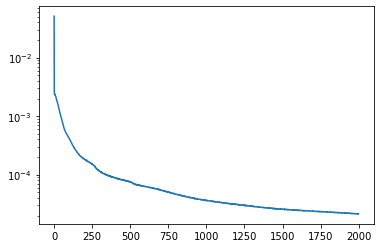

 Epoch 2000: Loss: 0.000004

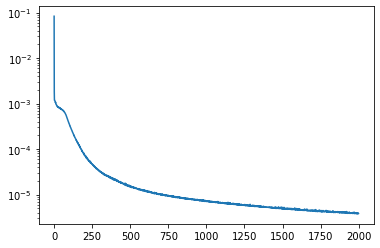

 Epoch 2000: Loss: 0.000025

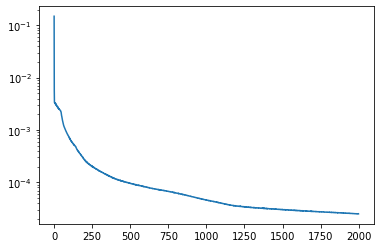

In [8]:
model_1 = deeponet()
model_1 = train_model(model_1,trainset_1,num_epochs)

model_2 = deeponet()
model_2 = train_model(model_2,trainset_2,num_epochs)

model_3 = deeponet()
model_3 = train_model(model_3,trainset_3,num_epochs)


In [7]:
model_1.save_weights('model/deeponet_1.h5')
model_2.save_weights('model/deeponet_2.h5')
model_3.save_weights('model/deeponet_3.h5')

'''
model_1 = deeponet()
model_2 = deeponet()
model_3 = deeponet()
model_1.build([(10000,1),(10000,1),(10000,2)])
model_2.build([(10000,1),(10000,1),(10000,2)])
model_3.build([(10000,1),(10000,1),(10000,2)])
model_1.load_weights('deeponet_1.h5')
model_2.load_weights('deeponet_2.h5')
model_3.load_weights('deeponet_3.h5')
'''

"\nmodel_1 = deeponet()\nmodel_2 = deeponet()\nmodel_3 = deeponet()\nmodel_1.build([(10000,1),(10000,1),(10000,2)])\nmodel_2.build([(10000,1),(10000,1),(10000,2)])\nmodel_3.build([(10000,1),(10000,1),(10000,2)])\nmodel_1.load_weights('deeponet_1.h5')\nmodel_2.load_weights('deeponet_2.h5')\nmodel_3.load_weights('deeponet_3.h5')\n"

In [9]:
test_model(model_1,testset_1)
test_model(model_2,testset_2)
test_model(model_3,testset_3)

 Test Loss: 0.000121
 Test Loss: 0.000005
 Test Loss: 0.000209


In [11]:
test_model_l1(model_1,testset_1)
test_model_l1(model_2,testset_2)
test_model_l1(model_3,testset_3)

 Test Loss: 0.008156
 Test Loss: 0.002275
 Test Loss: 0.004910
